# ``VAE2d`` Demo

To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``. To demonstrate ``torch_tools.VAE2d``, we use it to encode and decode MNIST images.

In [1]:
from torchvision.datasets import MNIST

First, we create the data sets.

In [2]:
from skimage.io import imread

from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, RandomRotation, ColorJitter

from numpy import array


def input_tfms(training: bool) -> Compose:
    """Return a composition of input transforms.

    Parameters
    ----------
    training : bool
        Are we training, or validating?

    """
    tfm_list = [array, ToTensor()]

    if training is True:
        tfm_list.append(
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        )
        tfm_list.append(RandomRotation(180.0))

    return Compose(tfm_list)


train_set = MNIST(
    root="MNIST",
    train=True,
    transform=input_tfms(True),
    download=True,
)

valid_set = MNIST(
    root="MNIST",
    train=False,
    transform=input_tfms(False),
    download=True,
)


bs = 64

train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=bs, shuffle=False)


And next, the model.

In [3]:
from torch.cuda import is_available
from torch import manual_seed

from torch_tools import VAE2d

manual_seed(123)


DEVICE = "cuda" if is_available() else "cpu"

model = VAE2d(
    in_chans=1,
    out_chans=1,
    # input_dims=(256, 256),
    num_layers=2,
    start_features=32,
    block_style="conv_res",
    mean_var_nets="conv",
).to(DEVICE)

print(f"Device set to {DEVICE}")

print(model)

Device set to cuda
VAE2d(
  (encoder): Encoder2d(
    (0): ConvResBlock(
      (0): ConvBlock(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ResidualBlock(
        (first_conv): ConvBlock(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.0)
        )
        (second_conv): ConvBlock(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      

Now, we set up the optimiser and loss function.

In [4]:
from torch.optim import Adam
from torch.nn import L1Loss
from torch.nn.functional import l1_loss

optimiser = Adam(model.parameters(), lr=1e-4)

And now we write our training loop.

In [5]:
from typing import Optional

from torch.nn import Module

from torch import set_grad_enabled


def one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Optional[Adam] = None,
) -> float:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    optimiser : Adam
        Adam optimiser.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    _ = model.train() if optimiser is not None else model.eval()
    metrics = {"l1_loss": 0.0, "kl_loss": 0.0}
    for batch, _ in data_loader:

        if optimiser is not None:
            optimiser.zero_grad()

        batch = batch.to(DEVICE)

        with set_grad_enabled(optimiser is not None):
            preds, kl_div = model(batch)

        sim_loss = l1_loss(preds.tanh(), batch)

        if optimiser is not None:
            (sim_loss + kl_div).backward()
            optimiser.step()

        metrics["l1_loss"] += sim_loss.item()
        metrics["kl_loss"] += kl_div.item()

    return {key: val / len(data_loader) for key, val in metrics.items()}

Now we can train the model.

In [6]:
from time import perf_counter

from numpy import floor

epochs = 10

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start = perf_counter()

    train_metrics.append(one_epoch(model, train_loader, optimiser))

    valid_metrics.append(one_epoch(model, valid_loader))

    stop = perf_counter()

    mins = int(floor((stop - start) / 60.0))
    secs = (stop - start) % 60.0

    print(f"{epoch + 1} Epoch time : {mins} mins and {secs:.3f} secs")


1 Epoch time : 0 mins and 19.388 secs
2 Epoch time : 0 mins and 18.692 secs
3 Epoch time : 0 mins and 18.470 secs
4 Epoch time : 0 mins and 18.471 secs
5 Epoch time : 0 mins and 18.389 secs
6 Epoch time : 0 mins and 18.465 secs
7 Epoch time : 0 mins and 19.504 secs
8 Epoch time : 0 mins and 18.614 secs
9 Epoch time : 0 mins and 18.531 secs
10 Epoch time : 0 mins and 18.714 secs


   l1_loss_train  kl_loss_train  l1_loss_valid  kl_loss_valid
0       0.070311       0.023616       0.035568       0.017010
1       0.040139       0.015496       0.029616       0.015825
2       0.031448       0.013812       0.019242       0.012972
3       0.026769       0.012641       0.017779       0.012611
4       0.025569       0.012595       0.017901       0.012591
5       0.025060       0.012596       0.016371       0.012781
6       0.024650       0.012575       0.016031       0.012724
7       0.024322       0.012580       0.016521       0.012521
8       0.024107       0.012568       0.016422       0.012815
9       0.023892       0.012555       0.015721       0.012787


Text(0, 0.5, 'Loss')

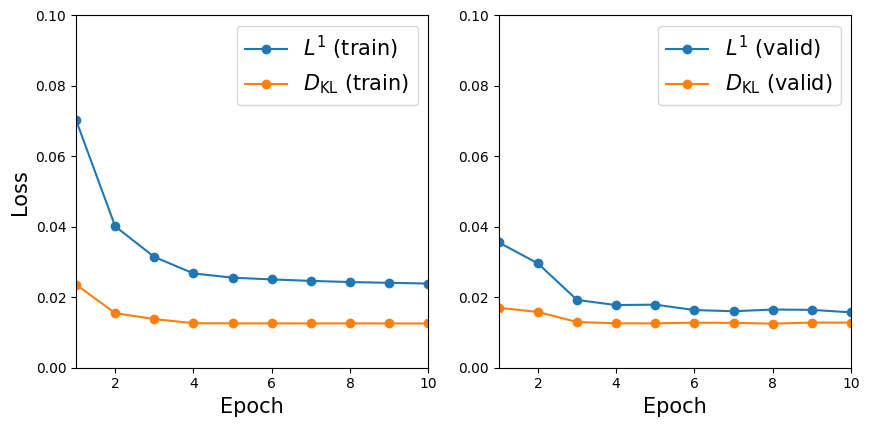

In [7]:
import matplotlib.pyplot as plt
from pandas import DataFrame

from numpy import linspace, diff


metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)

x_vals = linspace(1, len(metrics), len(metrics))

print(metrics)

figure, axes = plt.subplots(1, 2, figsize=(10, 5))

kl_str = r"$D_{\mathrm{KL}}$"


for split, axis in zip(["train", "valid"], axes.ravel()):

    axis.plot(x_vals, metrics[f"l1_loss_{split}"], "-o", label=rf"$L^{1}$ ({split})",)
    axis.plot(x_vals, metrics[f"kl_loss_{split}"], "-o", label=f"{kl_str} ({split})")


for axis in axes.ravel():
    axis.legend()

    axis.set_ylim(top=0.1, bottom=0.0)
    axis.set_xlim(left=1.0, right=len(metrics) if len(metrics) != 1 else None)

    axis.legend(fontsize=15)

    axis.set_xlabel("Epoch", fontsize=15)

    axis.set_aspect(diff(axis.get_xlim()) / diff(axis.get_ylim()))

axes[0].set_ylabel("Loss", fontsize=15)

Now we can take a look at some predictions from the validation loader.


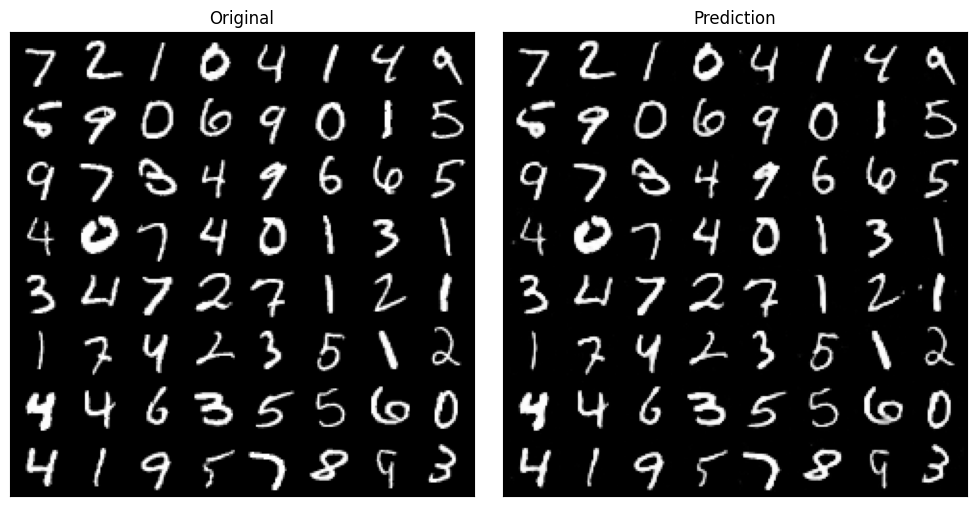

In [8]:
plt.close("all")

from torch import no_grad
from torchvision.utils import make_grid


for batch, _ in valid_loader:
    break


with no_grad():
    model.eval()
    preds, _ = model(batch.to(DEVICE))
    preds = preds.tanh().detach()


batch_grid = make_grid(batch.cpu(), nrow=8).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=8).permute(1, 2, 0)


pred_grid = pred_grid.clip(0.0, 1.0)


size = 2.5
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_title("Original")
axes[1].set_title("Prediction")

figure.tight_layout(h_pad=0.1)